#### Team 10: Personalized Medicine_Redefining Cancer Treatment

#### Team members: Carissa Huang, Le-Mei Shih, Jyothi Movva, Sai Vineesha Devathi, Akil Komarneni, Sai Sree Bollavaram

#### Data from Kaggle: https://www.kaggle.com/competitions/msk-redefining-cancer-treatment/overview


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.decomposition import TruncatedSVD


## Loading Test, Train data

In [2]:
#Read train_variants data
train_variants = pd.read_csv('training_variants.csv')
train_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
#Read train_text data
train_text =pd.read_csv("training_text.csv",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
train_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## Using nltk to process the text by removing numbers, spaces, stopwords and converting it into the lower case- On both train and test

In [4]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

In [5]:
#Define NLP processing function
def nlp_preprocessing(text, index, column):
    if type(text) is not int:
        string = ""
        # replace every special char with space
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
        # replace multiple spaces with single space
        text = re.sub('\s+',' ', text)
        # converting all the chars into lower-case.
        text = text.lower()
        
        for word in text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        train_text[column][index] = string
        

In [6]:
for index, row in train_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')

In [7]:
#Merging two train datasets
train_df = pd.merge(train_variants, train_text, on = 'ID', how = 'left')
#remove numeric values
train_df['TEXT'] = train_df['TEXT'].str.replace("\d","")
train_df

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...
...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,introduction myelodysplastic syndromes mds het...
3317,3317,RUNX1,A122*,1,introduction myelodysplastic syndromes mds het...
3318,3318,RUNX1,Fusions,1,runt related transcription factor gene runx a...
3319,3319,RUNX1,R80C,4,runx aml gene frequent target chromosomal tran...


## More on Train

In [8]:
#Check Train_df
train_df.describe(include='all')

,ID,Gene,Variation,Class,TEXT
count,3321.000000,3321,3321,3321.000000,3316
unique,NaN,264,2996,NaN,1920
top,NaN,BRCA1,Truncating Mutations,NaN,pten phosphatase tensin homolog phosphatase un...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


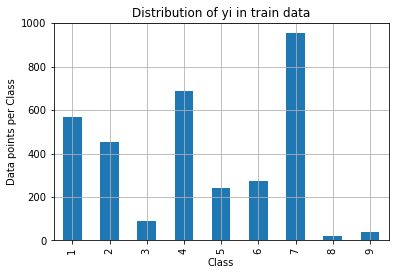

In [9]:
#check Class distribution
train_class_distribution = train_df['Class'].value_counts().sort_index()


my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

In [10]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':', train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%')

Number of data points in class 7 : 953 ( 28.696 %
Number of data points in class 4 : 686 ( 20.656 %
Number of data points in class 1 : 568 ( 17.103 %
Number of data points in class 2 : 452 ( 13.61 %
Number of data points in class 6 : 275 ( 8.281 %
Number of data points in class 5 : 242 ( 7.287 %
Number of data points in class 3 : 89 ( 2.68 %
Number of data points in class 9 : 37 ( 1.114 %
Number of data points in class 8 : 19 ( 0.572 %


#### Data Cleaning

In [11]:
#Check missing data
train_df[train_df.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


We replace the null values with Gene and Variation.

In [12]:
train_df.loc[train_df['TEXT'].isnull(),'TEXT'] = train_df['Gene'] +' '+train_df['Variation']

train_df['TEXT'].isnull().any()

False

In [13]:
#Clean 'Gene' and 'Variation' columns by replacing spaces with '_'
train_df.Gene = train_df.Gene.str.replace('\s+', '_')
train_df.Variation = train_df.Variation.str.replace('\s+', '_')

#### Feature engineering
For 'Gene' and 'Variation" clolumn, we will use one hotencoding.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests. For 'TEXT' column, we use TFIDF vectorization. 

#### TFIDF

In [14]:
tfidf = TfidfVectorizer(min_df=1, ngram_range=(1, 2), max_features=500)

train_text_tfidf = tfidf.fit_transform(train_df['TEXT'].values).toarray()
train_text_tfidf = pd.DataFrame(train_text_tfidf)
train_text_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.002415,0.000000,0.007117,0.004599,0.010571,0.002605,0.002702,0.005384,0.002133,0.005215,...,0.004280,0.010648,0.005960,0.005960,0.006175,0.007111,0.006712,0.030035,0.000000,0.017153
1,0.000000,0.008175,0.000000,0.006124,0.001876,0.000000,0.002398,0.004779,0.005679,0.000000,...,0.001899,0.003780,0.012344,0.012344,0.001827,0.006311,0.007943,0.014541,0.002770,0.000000
2,0.000000,0.008175,0.000000,0.006124,0.001876,0.000000,0.002398,0.004779,0.005679,0.000000,...,0.001899,0.003780,0.012344,0.012344,0.001827,0.006311,0.007943,0.014541,0.002770,0.000000
3,0.003144,0.017985,0.012353,0.002994,0.002752,0.006782,0.007034,0.010513,0.005553,0.000000,...,0.011143,0.019406,0.041379,0.041379,0.005359,0.018513,0.002912,0.014217,0.008125,0.000000
4,0.004012,0.000000,0.000000,0.022919,0.003512,0.002163,0.008975,0.000000,0.028342,0.030316,...,0.007109,0.001769,0.032999,0.032999,0.006838,0.003937,0.007432,0.000000,0.002592,0.000000


In [15]:
train_text_tfidf.shape

(3321, 500)

#### SVD

In [16]:
n_components = 70
svd_truncated = TruncatedSVD(n_components = n_components, n_iter=40, random_state=42)
truncated_train_text = pd.DataFrame(svd_truncated.fit_transform(train_text_tfidf))

truncated_train_text.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,0.267257,-0.073279,-0.093094,0.062339,-0.066911,-0.065934,-0.046179,-0.018874,-0.059415,0.036880,...,-0.007391,-0.046829,-0.045702,0.001033,0.024710,0.032173,-0.036901,-0.007492,0.000266,0.005481
1,0.239558,-0.080012,0.085317,-0.131432,0.048643,-0.041694,-0.097034,-0.024661,-0.023821,-0.000143,...,-0.018323,0.012428,0.024586,-0.010033,0.006558,0.017953,-0.008818,-0.032204,-0.012987,-0.034134
2,0.239558,-0.080012,0.085317,-0.131432,0.048643,-0.041694,-0.097034,-0.024661,-0.023821,-0.000143,...,-0.018323,0.012428,0.024586,-0.010033,0.006558,0.017953,-0.008818,-0.032204,-0.012987,-0.034134
3,0.289163,-0.066445,0.043859,-0.054762,-0.021869,-0.002977,0.031994,-0.050239,-0.026463,-0.018614,...,-0.001995,0.036077,0.040429,-0.009831,0.010324,-0.003279,-0.023767,-0.002679,0.003635,-0.002132
4,0.255781,-0.044282,0.092863,-0.044869,-0.020008,-0.050645,-0.062959,-0.035907,-0.025669,-0.027688,...,0.005320,0.020262,0.011473,0.004263,0.002673,0.001445,0.011302,0.010393,-0.014154,-0.015373


In [17]:
#Check uniqe genes
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 264
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
Name: Gene, dtype: int64


In [18]:
#Check uniqe variations
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 2996
Truncating_Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
G12V                     4
E17K                     3
T58I                     3
Q61R                     3
Q61H                     3
Name: Variation, dtype: int64


#### One hot coding

In [19]:
train_dummy = pd.get_dummies(train_df, columns=['Gene', 'Variation'], drop_first=True)

train_dummy.head()

,ID,Class,TEXT,Gene_ACVR1,Gene_AGO2,Gene_AKT1,Gene_AKT2,Gene_AKT3,Gene_ALK,Gene_APC,...,Variation_Y87N,Variation_Y901C,Variation_Y931C,Variation_Y98H,Variation_Y98N,Variation_YAP1-FAM118B_Fusion,Variation_YAP1-MAMLD1_Fusion,Variation_ZC3H7B-BCOR_Fusion,Variation_ZNF198-FGFR1_Fusion,Variation_p61BRAF
0,0,1,cyclin dependent kinases cdks regulate variety...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,abstract background non small cell lung cancer...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,abstract background non small cell lung cancer...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,recent evidence demonstrated acquired uniparen...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,oncogenic mutations monomeric casitas b lineag...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
train_dummy.shape

(3321, 3261)

#### Merge all vectors

In [21]:
train_text_tfidf[train_text_tfidf.isnull().any(axis=1)]

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499


In [22]:
#Merge dataframe
train_use = pd.merge(train_dummy, train_text_tfidf,  left_index=True, right_index=True)
train_use.head()

,ID,Class,TEXT,Gene_ACVR1,Gene_AGO2,Gene_AKT1,Gene_AKT2,Gene_AKT3,Gene_ALK,Gene_APC,...,490,491,492,493,494,495,496,497,498,499
0,0,1,cyclin dependent kinases cdks regulate variety...,0,0,0,0,0,0,0,...,0.004280,0.010648,0.005960,0.005960,0.006175,0.007111,0.006712,0.030035,0.000000,0.017153
1,1,2,abstract background non small cell lung cancer...,0,0,0,0,0,0,0,...,0.001899,0.003780,0.012344,0.012344,0.001827,0.006311,0.007943,0.014541,0.002770,0.000000
2,2,2,abstract background non small cell lung cancer...,0,0,0,0,0,0,0,...,0.001899,0.003780,0.012344,0.012344,0.001827,0.006311,0.007943,0.014541,0.002770,0.000000
3,3,3,recent evidence demonstrated acquired uniparen...,0,0,0,0,0,0,0,...,0.011143,0.019406,0.041379,0.041379,0.005359,0.018513,0.002912,0.014217,0.008125,0.000000
4,4,4,oncogenic mutations monomeric casitas b lineag...,0,0,0,0,0,0,0,...,0.007109,0.001769,0.032999,0.032999,0.006838,0.003937,0.007432,0.000000,0.002592,0.000000


In [23]:
train_use.isnull().any()

ID            False
Class         False
TEXT          False
Gene_ACVR1    False
Gene_AGO2     False
              ...  
495           False
496           False
497           False
498           False
499           False
Length: 3761, dtype: bool

In [24]:
train_use.isna().sum().sum()

0

## Creating train and test set 
We divided Train and Test sets into an 80% and 20%.

In [25]:
from sklearn.model_selection import train_test_split

x, y = train_use.drop(['ID', 'Class', 'TEXT'],axis=1), train_use['Class']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

print('Number if data points in train data:', x_train.shape[0])
print('Number if data points in text data:', x_test.shape[0])

Number if data points in train data: 2656
Number if data points in text data: 665


In [26]:
x_train.head()

,Gene_ACVR1,Gene_AGO2,Gene_AKT1,Gene_AKT2,Gene_AKT3,Gene_ALK,Gene_APC,Gene_AR,Gene_ARAF,Gene_ARID1A,...,490,491,492,493,494,495,496,497,498,499
305,0,0,0,0,0,0,0,0,0,0,...,0.009541,0.009494,0.004429,0.004429,0.009176,0.021134,0.004987,0.012173,0.013913,0.000000
863,0,0,0,0,0,0,0,0,0,0,...,0.016053,0.008875,0.014903,0.014903,0.015440,0.007902,0.037295,0.025033,0.026011,0.003574
1838,0,0,0,0,0,0,0,0,0,0,...,0.017470,0.002483,0.000000,0.000000,0.026404,0.000000,0.000000,0.003184,0.003639,0.000000
1932,0,0,0,0,0,0,0,0,0,0,...,0.012865,0.004267,0.011943,0.011943,0.012373,0.009499,0.004483,0.021885,0.006253,0.000000
1418,0,0,0,0,0,0,0,0,0,0,...,0.010294,0.011707,0.001365,0.001365,0.048091,0.001629,0.006150,0.000000,0.008578,0.000000


#### Model 1 - SVM

In [27]:
# Let's run Linear SVM model 
from sklearn import svm
from sklearn.metrics import classification_report
svc_model=svm.LinearSVC()
svc_model.fit(x_train,y_train)

#predicting the Test data using our trained Linear SVM model
y_pred = svc_model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.65      0.63      0.64       112
           2       0.58      0.46      0.51        93
           3       0.50      0.08      0.13        13
           4       0.69      0.76      0.73       119
           5       0.32      0.13      0.18        46
           6       0.63      0.65      0.64        52
           7       0.72      0.89      0.80       220
           8       0.00      0.00      0.00         3
           9       1.00      0.43      0.60         7

    accuracy                           0.67       665
   macro avg       0.57      0.45      0.47       665
weighted avg       0.64      0.67      0.65       665



#### Model 2 - Logistic Regression 

In [28]:
# Let's run Logistic regression model 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression()
logsk.fit(x_train,y_train)
y_pred = logsk.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.65      0.62      0.63       112
           2       0.54      0.40      0.46        93
           3       0.00      0.00      0.00        13
           4       0.63      0.75      0.68       119
           5       0.25      0.09      0.13        46
           6       0.72      0.63      0.67        52
           7       0.69      0.90      0.78       220
           8       0.00      0.00      0.00         3
           9       1.00      0.29      0.44         7

    accuracy                           0.65       665
   macro avg       0.50      0.41      0.42       665
weighted avg       0.61      0.65      0.62       665



#### Model 3 -Random Forest Classification 

In [29]:
# Let's run Random Forest model 
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=300)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.57      0.59      0.58       112
           2       0.63      0.35      0.46        93
           3       0.29      0.31      0.30        13
           4       0.64      0.71      0.67       119
           5       0.43      0.26      0.32        46
           6       0.74      0.65      0.69        52
           7       0.69      0.86      0.77       220
           8       0.00      0.00      0.00         3
           9       1.00      0.43      0.60         7

    accuracy                           0.64       665
   macro avg       0.55      0.46      0.49       665
weighted avg       0.63      0.64      0.62       665



#### Model 4 - Bagging Classifier

In [30]:
# Let's run Bagging Classifier model
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Set seed for reproducibility
SEED = 1
# Split data into train and test
x_train, x_test, y_train, y_test = \
train_test_split(x, y,
test_size=0.2,
stratify=y,
random_state=SEED)

# Instantiate a classification-tree 'dt'
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.16,
random_state=SEED)
# Instantiate a BaggingClassifier 'bc'
bc = BaggingClassifier(base_estimator=dt, n_estimators=300,
n_jobs=-1)
# Fit 'bc' to the training set
bc.fit(x_train, y_train)
# Predict test set labels
y_pred = bc.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.25      0.32      0.28       114
           2       0.00      0.00      0.00        91
           3       0.00      0.00      0.00        18
           4       0.39      0.64      0.48       137
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        55
           7       0.51      0.80      0.62       191
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7

    accuracy                           0.41       665
   macro avg       0.13      0.19      0.15       665
weighted avg       0.27      0.41      0.33       665



#### Model 5 - Boosting

In [31]:
# Let's run Boosting model
from sklearn.ensemble import AdaBoostClassifier
# Instantiate ada
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=180, random_state=1)
ada.fit(x_train, y_train)
y_pred = ada.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.31      0.54      0.39       114
           2       0.24      0.25      0.25        91
           3       0.14      0.17      0.15        18
           4       0.36      0.34      0.35       137
           5       0.12      0.06      0.08        48
           6       0.21      0.05      0.09        55
           7       0.56      0.52      0.54       191
           8       0.50      0.25      0.33         4
           9       0.67      0.29      0.40         7

    accuracy                           0.36       665
   macro avg       0.34      0.27      0.29       665
weighted avg       0.36      0.36      0.35       665



Reference:
1. https://www.kaggle.com/code/abdulmeral/tabular-nlp
2. https://www.kaggle.com/code/vishvdeep/logistic-regregression
3. https://github.com/ROHANNAIK/Personalized-Medicine-Redefining-Cancer-Treatment
4. https://www.kaggle.com/code/kasevgen/tfidf-xgboost-predict-for-medicine-treatment